In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
with open("data/tinyshakespeare.txt", "r") as f:
    text = f.read()

In [3]:
print(f"Text len: {len(text)}")
VOCAB = set(text)
VOCAB_SIZE = len(VOCAB)
print(f"Vocab size: {VOCAB_SIZE}")

Text len: 1115394
Vocab size: 65


In [4]:
itos = {i: s for i, s in enumerate(VOCAB)}
stoi = {s: i for i, s in itos.items()}

In [5]:
dataset = torch.tensor([stoi[s] for s in text])

In [6]:
x, y = dataset[:-1], dataset[1:]


def train_test_idxs(N, p=0.9):
    idxs = torch.randperm(N)
    split_idx = int(N * p)
    train_idxs = idxs[:split_idx]
    test_idxs = idxs[split_idx:]
    return train_idxs, test_idxs


def make_batch(train_size, n=100):
    return torch.randint(0, train_size, (n,))

In [7]:
(N,) = x.shape
train_idxs, test_idxs = train_test_idxs(N)
train_x, train_y, test_x, test_y = x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

In [8]:
flat_indices = train_x * VOCAB_SIZE + train_y
counts = torch.bincount(flat_indices, minlength=VOCAB_SIZE * VOCAB_SIZE)
counts = counts.view(VOCAB_SIZE, VOCAB_SIZE)

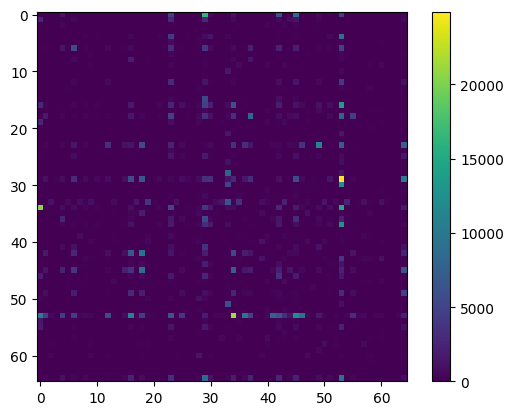

In [9]:
plt.imshow(counts)
plt.colorbar()
plt.show()

In [10]:
probs = counts / counts.sum(1, keepdim=True)

In [11]:
def bgram_model(x):
    return probs[x]

In [12]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim) -> None:
        self.emb = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, idx):
        return self.emb[idx]

    def parameters(self):
        return [self.emb]


class Flatten:
    def __call__(self, x):
        if len(x.shape) == 2:
            return x
        B, T, E = x.shape
        return x.view(B, T * E)

    def parameters(self):
        return []


class Linear:
    def __init__(self, in_features, out_features):
        self.w = torch.randn(in_features, out_features) * 0.1
        self.b = torch.zeros(out_features)

    def __call__(self, x):
        return x @ self.w + self.b

    def parameters(self):
        return [self.w, self.b]


class Relu:
    def __call__(self, x):
        return x.relu()

    def parameters(self):
        return []


class Sequential:
    def __init__(self, *args):
        self.layers = args

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
def train(model, iters=10_000, lr=0.01):
    for i in range(iters):
        for p in model.parameters():
            p.grad = None

        batch_idx = make_batch(train_x.shape[0], 1_000)
        batch_x, batch_y = train_x[batch_idx], train_y[batch_idx]
        output = model(batch_x)
        loss = F.cross_entropy(output, batch_y)

        if not i % 100:
            print(f"{i}: {loss}")

        loss.backward()
        for p in model.parameters():
            p.data -= p.grad * lr

In [14]:
N = 1
N_HIDDEN = 100
EMB_DIM = VOCAB_SIZE

simple_model = Sequential(
    Embedding(VOCAB_SIZE, EMB_DIM)
)

print(f"total elements: {sum(p.nelement() for p in simple_model.parameters())}")

for p in simple_model.parameters():
    p.requires_grad = True



total elements: 4225


In [15]:
train(simple_model, 20_000)

0: 4.606263637542725
100: 4.556361675262451
200: 4.624560356140137
300: 4.635373115539551
400: 4.5750203132629395
500: 4.553737640380859
600: 4.591209411621094
700: 4.56116247177124
800: 4.559753894805908
900: 4.548775672912598
1000: 4.506012916564941
1100: 4.585481643676758
1200: 4.53521203994751
1300: 4.536750793457031
1400: 4.513175964355469
1500: 4.522669792175293
1600: 4.491037368774414
1700: 4.50109338760376
1800: 4.577879428863525
1900: 4.522156238555908
2000: 4.498720169067383
2100: 4.438619613647461
2200: 4.522666931152344
2300: 4.4512619972229
2400: 4.500085353851318
2500: 4.486637115478516
2600: 4.432735919952393
2700: 4.423845291137695
2800: 4.459962368011475
2900: 4.497987270355225
3000: 4.373526096343994
3100: 4.431204319000244
3200: 4.489809513092041
3300: 4.418598651885986
3400: 4.403860569000244
3500: 4.3845343589782715
3600: 4.39586877822876
3700: 4.380120754241943
3800: 4.3572492599487305
3900: 4.445469856262207
4000: 4.3675312995910645
4100: 4.410482406616211
4200: 

In [17]:
from math import log

loss = -log(1/VOCAB_SIZE) 
print(f"uniform prediction loss: {loss}")

pred = simple_model(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"mlp loss: {loss}")

pred = bgram_model(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"bgram loss: {loss}")

uniform prediction loss: 4.174387269895637
mlp loss: 3.753809928894043
bgram loss: 4.038746356964111


In [21]:
N = 1
N_HIDDEN = 100
EMB_DIM = 2

mlp = Sequential(
    Embedding(VOCAB_SIZE, EMB_DIM), Flatten(), Linear(N * EMB_DIM, N_HIDDEN), Relu(), Linear(N_HIDDEN, VOCAB_SIZE)
)

print(f"total elements: {sum(p.nelement() for p in mlp.parameters())}")

for p in mlp.parameters():
    p.requires_grad = True

total elements: 6995


In [22]:
train(mlp, 20_000)

0: 4.166912078857422
100: 4.09208345413208
200: 4.022213459014893
300: 3.9496381282806396
400: 3.8808112144470215
500: 3.7817163467407227
600: 3.7215840816497803
700: 3.640411138534546
800: 3.621298313140869
900: 3.525974988937378
1000: 3.5071704387664795
1100: 3.473824977874756
1200: 3.440014362335205
1300: 3.4066121578216553
1400: 3.4027040004730225
1500: 3.4102702140808105
1600: 3.362412452697754
1700: 3.3295788764953613
1800: 3.3358097076416016
1900: 3.3451037406921387
2000: 3.268907308578491
2100: 3.3335087299346924
2200: 3.2539725303649902
2300: 3.2128708362579346
2400: 3.301744222640991
2500: 3.311796188354492
2600: 3.262007713317871
2700: 3.283858299255371
2800: 3.242403030395508
2900: 3.2678933143615723
3000: 3.2814087867736816
3100: 3.298929452896118
3200: 3.2112877368927
3300: 3.2199594974517822
3400: 3.198521375656128
3500: 3.1296944618225098
3600: 3.233552932739258
3700: 3.246673345565796
3800: 3.233304023742676
3900: 3.1884121894836426
4000: 3.277292013168335
4100: 3.2902

In [24]:
pred = mlp(test_x)
loss = F.cross_entropy(pred, test_y)
print(f"mlp loss: {loss}")

mlp loss: 2.9052071571350098


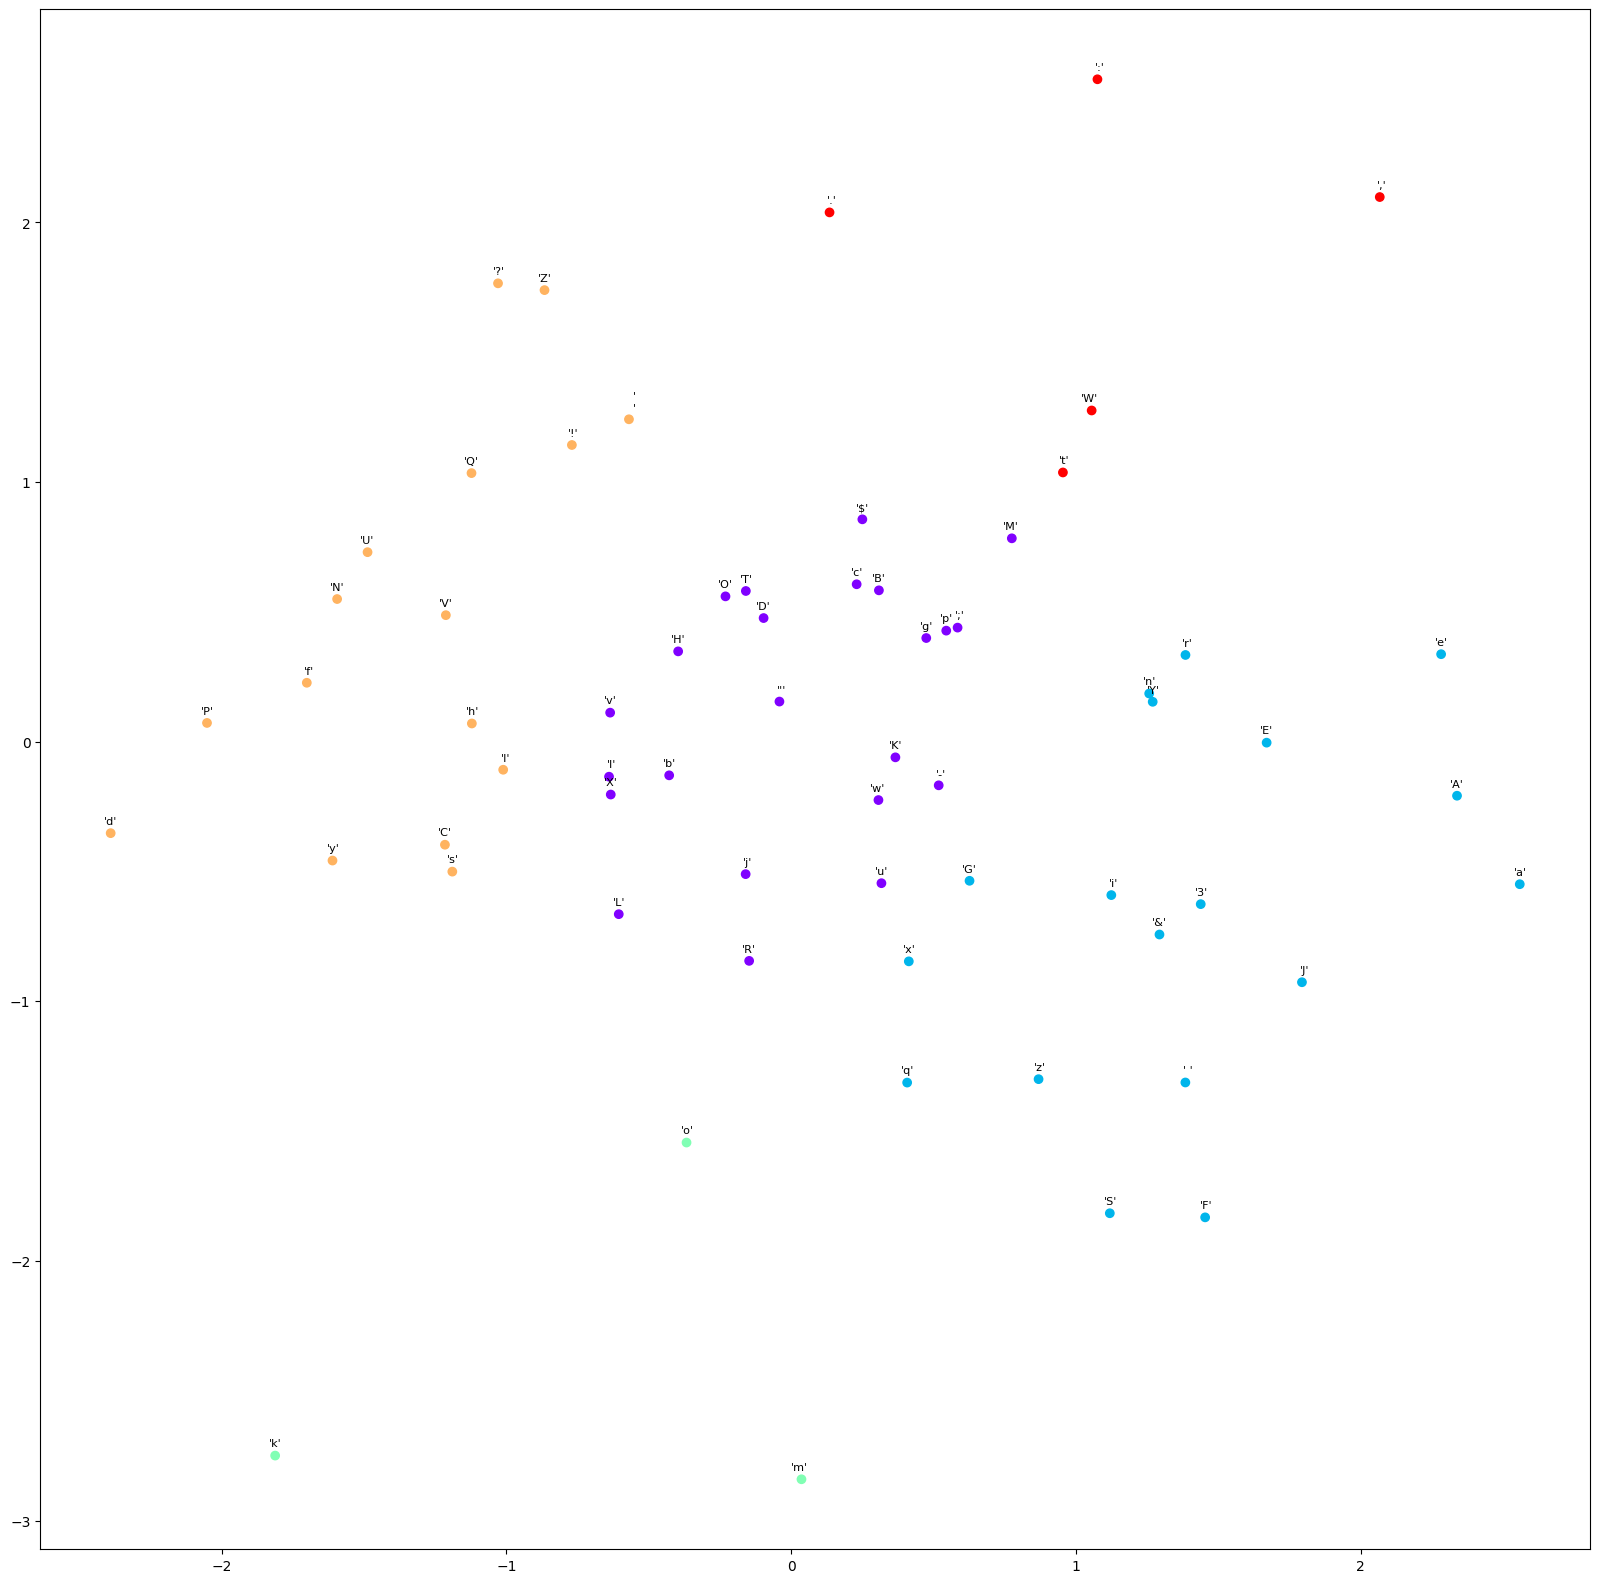

In [25]:
from sklearn.cluster import KMeans
import numpy as np

symbols = mlp.layers[0].parameters()[0].detach()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(symbols)


colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(20, 20))
plt.scatter(symbols[:, 0], symbols[:, 1], c=colors[clusters])
for i, s in itos.items():

    plt.annotate(f"'{s}'",
                 xy=(symbols[i, 0], symbols[i, 1]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=8)